This notebook reproduces the qualitative experiments presented in the paper (Section 4.1). In order for it to run, the preprocessed VAST dataset must first be extracted using the `extract_vast_dataset.py` script (located in the `data/vast/` folder). The dataset is assumed to be located at `data/vast/vast.csv`.

In [1]:
import datetime as dt
import json
import sys

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sys.path.insert(0, '../code/')
from snmf import SuperposedNMF

In [2]:
COLORS = ['#4477AA', '#228833', '#AA3377', '#CCBB44', '#66CCEE']

In [3]:
def plot_snmf_weights(est, dates, ax, xticks=None, with_labels=True, with_legend=False):
    '''
    Helper function.
    Plots the mixing coefficients inferred by SNMF as a function of time.
    '''
    for l, w in enumerate(est.W.T):
        y = []
        timestamps = dict(zip(est.timestamps, range(len(est.timestamps))))
        for i, date in enumerate(dates):
            if i in timestamps:
                y.append(w[timestamps[i]])
            else:
                y.append(0)
        y = np.array(y)
        mean_prod = np.matmul(
            est.U[l, :, :],
            est.V[l, :, :].T
        ).mean()
        ax.plot(
            y * mean_prod,
            color=COLORS[l],
            label=f'Source {l + 1}'
        )
    if xticks is not None:
        ticks = xticks
    else:
        ticks = [i for i, _ in enumerate(dates) if i % 12 == 0]
    if with_labels:
            ax.set_xticks(
            ticks,
            labels=[dates[t].strftime('%a %H:%M') for t in ticks],
            rotation=45
        )
    else:
        ax.set_xticks(
            ticks,
            labels=[]
        )
    ax.set_yticks([])
    ax.set_ylabel('Magnitude')
    ax.grid(axis='x')
    if with_legend:
        ax.legend(ncol=est.n_estimators)

First, let's load the dataset.

In [4]:
df = pd.read_csv('../data/vast/vast.csv')
X = df.to_numpy()

Then, let's train SNMF on the VAST temporal graph:

In [5]:
est = SuperposedNMF(
    n_estimators=4,
    dimension=5,
    rescale='binary',
    random_state=0,
    l2_coeff_UV=1e-5,
    lasso_coeff_W=1e-3,
    verbose=1
).fit(X)

Starting training; K=5, L=4, lambda1=0.001, lambda2=1e-05
Training stopped after 192 iterations; final score: 0.5767779965041955


In order to analyze the inferred activity sources, we cluster the nodes based on their embeddings for each source.
We use the $k$-means algorithms and set the number of clusters by maximizing the silhouette score.

In [6]:
H = np.concatenate([est.U, est.V], axis=2)
H /= np.linalg.norm(H, axis=2, ord=2)[:, :, np.newaxis] + 1e-10
H_global = np.concatenate([H[l, :, :] for l in range(H.shape[0])], axis=1)
K = 12
clust = []
for l in range(H.shape[0]):
    kmeans = [
        KMeans(n_clusters=k, n_init=10, random_state=0).fit(H[l, :, :])
        for k in range(2, K + 1)
    ]
    clust.append(
        sorted(
            kmeans,
            key=lambda c: silhouette_score(
                H[l, :, :],
                c.labels_
            )
        )[-1]
    )

We can now take a look at the contents of the clusters:

In [7]:
for i in range(est.n_estimators):
    print([len(np.where(clust[i].labels_ == k)[0]) for k in range(clust[i].n_clusters)])

[55, 161, 344, 363, 71, 189, 100, 54, 29, 45, 12, 4]
[465, 607, 152, 101, 102]
[176, 202, 308, 300, 278, 11, 152]
[710, 270, 227, 220]


In [8]:
est.node_enc.inverse_transform(np.where(clust[0].labels_ == 0)[0])

array(['172.10.2.106', '172.30.1.201', '172.30.1.202', '172.30.1.203',
       '172.30.1.204', '172.30.1.205', '172.30.1.206', '172.30.1.207',
       '172.30.1.208', '172.30.1.209', '172.30.1.210', '172.30.1.211',
       '172.30.1.212', '172.30.1.213', '172.30.1.214', '172.30.1.215',
       '172.30.1.216', '172.30.1.217', '172.30.1.218', '172.30.1.219',
       '172.30.1.220', '172.30.1.221', '172.30.1.222', '172.30.1.223',
       '172.30.1.224', '172.30.1.225', '172.30.1.226', '172.30.1.227',
       '172.30.1.228', '172.30.1.229', '172.30.1.230', '172.30.1.231',
       '172.30.1.232', '172.30.1.233', '172.30.1.234', '172.30.1.235',
       '172.30.1.236', '172.30.1.237', '172.30.1.238', '172.30.1.239',
       '172.30.1.240', '172.30.1.241', '172.30.1.242', '172.30.1.243',
       '172.30.1.244', '172.30.1.245', '172.30.1.246', '172.30.1.247',
       '172.30.1.248', '172.30.1.249', '172.30.1.250', '172.30.1.251',
       '172.30.1.252', '172.30.1.253', '172.30.1.254'], dtype='<U15')

Next, we would like to visualize each activity source by extracting the predicted edges between the clusters we just found. First, let's take a look at the distribution of the predicted scores for each source and define a reasonable threshold to distinguish positive edges from negative ones.

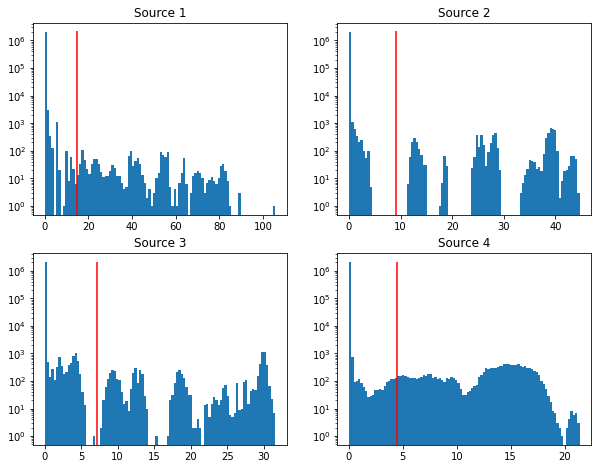

In [9]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(10, 12)
axes = axes.flatten()
thresh = []
for i, ax in enumerate(axes[:est.n_estimators]):
    values = np.matmul(
        est.U[i, :, :],
        est.V[i, :, :].T
    ).flatten()
    # Define a cutoff threshold to binarize the values
    thresh.append(.25 / est.W[:, i].max())
    ax.hist(
        values,
        bins=100
    )
    # Display the threshold along with the distribution
    ax.vlines(thresh[-1], 0, ax.get_ylim()[1], color='red')
    ax.set_yscale('log')
    ax.set_title(f'Source {i+1}')
for i in range(est.n_estimators, len(axes)):
    fig.delaxes(axes[i])

Then, we display the number of edges (i.e., scores above the threshold) between each pair of clusters for each activity source:

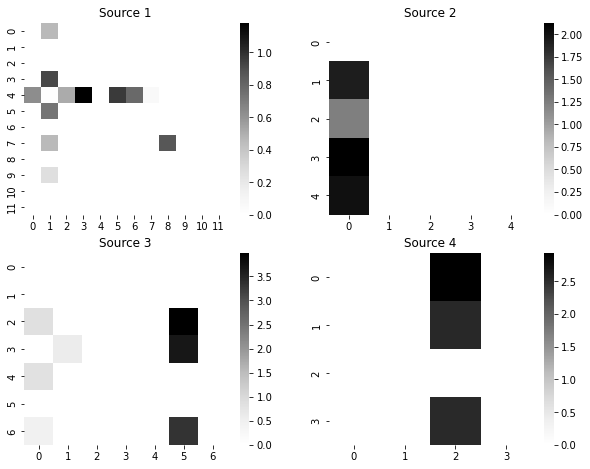

In [10]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(10, 12)
axes = axes.flatten()
for i, ax in enumerate(axes[:est.n_estimators]):
    K = clust[i].n_clusters
    A = np.zeros((K, K))
    for k in range(K):
        k_idx = np.where(clust[i].labels_ == k)
        for l in range(K):
            if l != k or True:
                l_idx = np.where(clust[i].labels_ == l)
                prod = np.matmul(
                    est.U[i, k_idx, :],
                    est.V[i, l_idx, :].transpose(0, 2, 1)
                )
                A[k, l] = (
                    prod >= thresh[i]
                ).sum() / np.sqrt(len(k_idx[0]) * len(l_idx[0]))
    sns.heatmap(np.log(1 + A), ax=ax, cmap='Greys')
    ax.set_title(f'Source {i+1}')
for i in range(est.n_estimators, len(axes)):
    fig.delaxes(axes[i])

Finally, we can plot the evolution of the mixing coefficients over time:

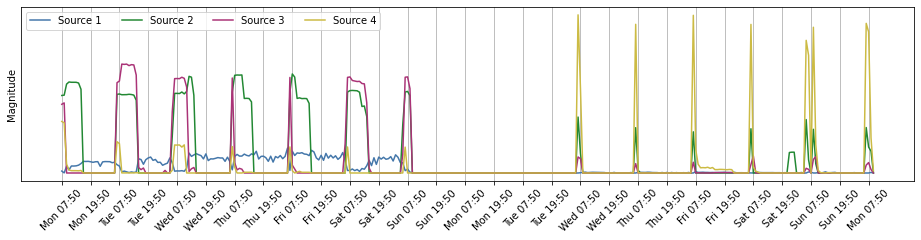

In [11]:
start_date = dt.datetime(2013, 4, 1, 7, 50, 16)
dates = [start_date + dt.timedelta(seconds=3600 * t) for t in range(max(est.timestamps) + 1)]
fig = plt.figure(figsize=(16, 3.2))
plot_snmf_weights(est, dates, plt.axes(), with_legend=True)